## Import

In [3]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from ngboost import NGBClassifier
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score

In [18]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings(action='default')

## Load

In [5]:
out_data_path = 'C:\\Users\\PC0\\Documents\\datasets\\stock_price\\'
data_path = 'C:\\Users\\PC0\\Documents\\GitHub\\Stock-price-prediction\\datasets\\'

In [6]:
stock_df = pd.read_csv(data_path + "stock_df_01.csv")

In [7]:
n_target = np.array(list(stock_df.target))
c_target = np.array(list(stock_df.c_target))

In [8]:
del stock_df['target']
del stock_df['c_target']

In [9]:
stock_df.shape

(2410, 372)

In [10]:
var_cols = [x for x in stock_df.columns if "var" in x]

In [11]:
stock_df.head()

,date,kosdaq_close,kosdaq_vol,kosdaq_var,us-30_close,us-30_vol,us-30_var,us-spx-500_close,us-spx-500_var,nasdaq-composite_close,...,영국_아연_close,영국_아연_vol,영국_아연_var,은_close,은_vol,은_var,영국_주석_close,영국_주석_var,미국_팔라듐_close,미국_팔라듐_var
0,2012-01-03,513.83,590990.0,1.39,12397.38,152560000.0,1.47,1277.06,1.55,2648.72,...,1864.25,9410.0,1.83,29.533,140.0,4.88,19949.0,4.13,664.8,1.42
1,2012-01-04,516.30,652090.0,0.48,12418.42,145130000.0,0.17,1277.30,0.02,2648.36,...,1856.50,8430.0,-0.42,29.063,70.0,-1.59,19555.0,-1.98,649.9,-2.24
2,2012-01-05,521.96,654300.0,1.10,12415.70,158440000.0,-0.02,1281.06,0.29,2669.86,...,1821.25,7720.0,-1.90,29.265,30.0,0.70,19814.0,1.32,640.4,-1.46
3,2012-01-06,518.94,626020.0,-0.58,12359.92,131120000.0,-0.45,1277.81,-0.25,2674.22,...,1840.75,7120.0,1.07,28.653,80.0,-2.09,19807.0,-0.04,616.1,-3.79
4,2012-01-09,520.28,617370.0,0.26,12392.69,122200000.0,0.27,1280.70,0.23,2676.56,...,1870.25,9620.0,1.60,28.749,60.0,-0.34,19746.0,-0.31,620.0,0.63


## Modeling

* label portion 탐색

In [99]:
Counter(whole_truth)

Counter({0: 1088, 1: 1221})

In [101]:
1221/(1088+1221)

0.5288003464703335

* baseline modeling - moving window

In [12]:
# temp_x = stock_df.loc[:, var_cols]
temp_x = stock_df.iloc[:, 1:]

In [13]:
temp_x.head()

,kosdaq_close,kosdaq_vol,kosdaq_var,us-30_close,us-30_vol,us-30_var,us-spx-500_close,us-spx-500_var,nasdaq-composite_close,nasdaq-composite_vol,...,영국_아연_close,영국_아연_vol,영국_아연_var,은_close,은_vol,은_var,영국_주석_close,영국_주석_var,미국_팔라듐_close,미국_팔라듐_var
0,513.83,590990.0,1.39,12397.38,152560000.0,1.47,1277.06,1.55,2648.72,411790000.0,...,1864.25,9410.0,1.83,29.533,140.0,4.88,19949.0,4.13,664.8,1.42
1,516.30,652090.0,0.48,12418.42,145130000.0,0.17,1277.30,0.02,2648.36,411090000.0,...,1856.50,8430.0,-0.42,29.063,70.0,-1.59,19555.0,-1.98,649.9,-2.24
2,521.96,654300.0,1.10,12415.70,158440000.0,-0.02,1281.06,0.29,2669.86,442080000.0,...,1821.25,7720.0,-1.90,29.265,30.0,0.70,19814.0,1.32,640.4,-1.46
3,518.94,626020.0,-0.58,12359.92,131120000.0,-0.45,1277.81,-0.25,2674.22,412310000.0,...,1840.75,7120.0,1.07,28.653,80.0,-2.09,19807.0,-0.04,616.1,-3.79
4,520.28,617370.0,0.26,12392.69,122200000.0,0.27,1280.70,0.23,2676.56,447700000.0,...,1870.25,9620.0,1.60,28.749,60.0,-0.34,19746.0,-0.31,620.0,0.63


In [34]:
train_volum = 100
train_start_idx = 0
sample_days = 5

data = temp_x

model_xgb = XGBClassifier()
model_lgbm = LGBMClassifier()
model_ngb = NGBClassifier()
model_cat = CatBoostClassifier(verbose = False)

model = model_cat

In [35]:
c_target_num = np.where(c_target == "Up", 1, 0)
c_target_num = pd.DataFrame(c_target_num)

In [36]:
pred_dict = {}

In [37]:
train_end_idx = train_start_idx + train_volum
test_start_idx = train_end_idx + 1

whole_predict = []
whole_proba = []
whole_truth = []
whole_acc = []

print("Start Fitting..")
for _ in tqdm(range(data.shape[0] - (train_volum + 1))) :
    temp_train_x = data.loc[train_start_idx:train_end_idx,:]
    temp_train_y = c_target_num.loc[train_start_idx:train_end_idx]
    temp_test_x = data.loc[test_start_idx:test_start_idx,:]
    temp_test_y = c_target_num.loc[test_start_idx]

    # append sample
    temp_train_x = temp_train_x.append(temp_train_x.loc[(train_end_idx - sample_days):])
    temp_train_y = temp_train_y.append(temp_train_y.loc[(train_end_idx - sample_days):])

    # fitting
    model.fit(temp_train_x,temp_train_y)
    # predict
    predict_value = model.predict(temp_test_x)
    whole_proba.append(model.predict_proba(temp_test_x)[0])

    # save acc
    pred_dict[stock_df.date[test_start_idx]] = predict_value[0]
    whole_predict.append(predict_value[0])
    whole_truth.append(temp_test_y.iloc[0])

    train_start_idx += 1
    train_end_idx = train_start_idx + train_volum
    test_start_idx = train_end_idx + 1

print("Finish")

  0%|                                                                                         | 0/2309 [00:00<?, ?it/s]

Start Fitting..


100%|████████████████████████████████████████████████████████████████████████████| 2309/2309 [6:26:34<00:00, 10.05s/it]

Finish


* catboost performance

In [38]:
accuracy_score(whole_truth, whole_predict)

0.5747076656561282

In [39]:
precision_score(whole_truth, whole_predict)

0.5897821187077386

In [40]:
recall_score(whole_truth, whole_predict)

0.642915642915643

In [41]:
f1_score(whole_truth, whole_predict)

0.6152037617554859

In [42]:
cohen_kappa_score(whole_truth, whole_predict)

0.14185854111584528

In [43]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [44]:
1 - np.mean(np.array(whole_truth)[zero_idx])

1.0

In [45]:
np.mean(np.array(whole_truth)[one_idx])

0.6923076923076923

* xgboost performance

In [20]:
accuracy_score(whole_truth, whole_predict)

0.5574738755111313

In [21]:
precision_score(whole_truth, whole_predict)

0.5817427385892117

In [22]:
recall_score(whole_truth, whole_predict)

0.5986336464560205

In [23]:
f1_score(whole_truth, whole_predict)

0.5900673400673402

In [24]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.10953093418557103

In [27]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [28]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.6126984126984127

In [29]:
np.mean(np.array(whole_truth)[one_idx])

0.6202290076335878

* ligtgbm performance

In [93]:
accuracy_score(whole_truth, whole_predict)

0.5712429623213512

In [94]:
precision_score(whole_truth, whole_predict)

0.5900233826968043

In [95]:
recall_score(whole_truth, whole_predict)

0.61998361998362

In [96]:
f1_score(whole_truth, whole_predict)

0.6046325878594249

In [97]:
cohen_kappa_score(whole_truth, whole_predict)

0.13695278726898608

In [149]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [150]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.6079136690647482

In [151]:
np.mean(np.array(whole_truth)[one_idx])

0.6206896551724138

In [82]:
beta1 = 0.99
beta2 = 0.995
beta3 = 0.9975
beta4 = 0.999

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
x1 = [beta1**x for x in range(1000)]
x2 = [beta2**x for x in range(1000)]
x3 = [beta3**x for x in range(1000)]
x4 = [beta4**x for x in range(1000)]

<AxesSubplot:>

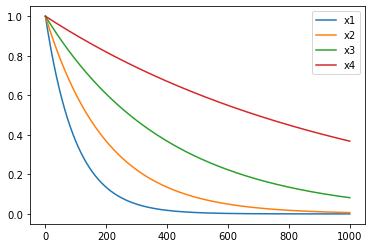

In [84]:
pd.DataFrame({"x1": x1, "x2": x2, "x3":x3,"x4":x4}).plot()

* baseline modeling - stacked sample

In [184]:
from sklearn.metrics.pairwise import cosine_similarity

In [198]:
train_volum = 100
train_start_idx = 0
sample_days = 5

data = temp_x

model_xgb = XGBClassifier()
model_lgbm = LGBMClassifier()
model_ngb = NGBClassifier()
model_cat = CatBoostClassifier(verbose = False)

model = model_lgbm

In [199]:
c_target_num = np.where(c_target == "Up", 1, 0)
c_target_num = pd.DataFrame(c_target_num)

In [200]:
pred_dict = {}

In [201]:
beta = 0.999

In [202]:
train_end_idx = train_start_idx + train_volum
test_start_idx = train_end_idx + 1

whole_predict = []
whole_proba = []
whole_truth = []
whole_acc = []

print("Start Fitting..")
for _ in tqdm(range(data.shape[0] - (train_volum + 1))) :
    temp_train_x = data.loc[:train_end_idx,:]
    temp_train_y = c_target_num.loc[:train_end_idx]
    temp_test_x = data.loc[test_start_idx:test_start_idx,:]
    temp_test_y = c_target_num.loc[test_start_idx]

    # append sample
    temp_train_x = temp_train_x.append(temp_train_x.loc[(train_end_idx - sample_days):])
    temp_train_y = temp_train_y.append(temp_train_y.loc[(train_end_idx - sample_days):])
    
    sim_mat = cosine_similarity(np.array(temp_train_x))
    
    #sample_w = [beta ** x for x in range((temp_train_x.shape[0]), 0, -1)]
    #sample_w = np.array(sample_w) + 1-np.mean(sample_w)
    
    # fitting
    #model.fit(temp_train_x,temp_train_y, sample_weight=sample_w)
    model.fit(temp_train_x,temp_train_y, sample_weight=sim_mat[-1])
    #model.fit(temp_train_x,temp_train_y)
    
    # predict
    predict_value = model.predict(temp_test_x)
    whole_proba.append(model.predict_proba(temp_test_x)[0])

    # save acc
    pred_dict[stock_df.date[test_start_idx]] = predict_value[0]
    whole_predict.append(predict_value[0])
    whole_truth.append(temp_test_y.iloc[0])

    train_start_idx += 1
    train_end_idx = train_start_idx + train_volum
    test_start_idx = train_end_idx + 1

print("Finish")

  0%|                                                                                         | 0/2309 [00:00<?, ?it/s]C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\PC0\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  0%|                                                                                 | 1/2309 [00:00<04:06,  9.35it/s]C:\Users\PC0\anaconda3\lib\site-packages\sklea

Start Fitting..


C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\PC0\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  0%|                                                                                 | 3/2309 [00:00<04:02,  9.50it/s]C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence thi

Finish


* lightgbm performance - with sample weights using cosine sim

In [203]:
accuracy_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6011260285838025

In [204]:
precision_score(whole_truth, whole_predict)

0.6141552511415526

In [205]:
recall_score(whole_truth, whole_predict)

0.6609336609336609

In [206]:
f1_score(whole_truth, whole_predict)

0.6366863905325445

In [207]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.19585279333506522

In [208]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [209]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.7035714285714285

In [210]:
np.mean(np.array(whole_truth)[one_idx])

0.6814988290398126

* lightgbm performance - with sample weights 0.999 beta adjust

In [165]:
accuracy_score(whole_truth, whole_predict)

0.6145517540060632

In [166]:
precision_score(whole_truth, whole_predict)

0.6258555133079848

In [167]:
recall_score(whole_truth, whole_predict)

0.674037674037674

In [168]:
f1_score(whole_truth, whole_predict)

0.6490536277602523

In [169]:
cohen_kappa_score(whole_truth, whole_predict)

0.22288055410804897

In [170]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [171]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.7320754716981133

In [172]:
np.mean(np.array(whole_truth)[one_idx])

0.6857142857142857

* lightgbm performance - with sample weights 0.9975 beta

In [107]:
accuracy_score(whole_truth, whole_predict)

0.6007020623080298

In [108]:
precision_score(whole_truth, whole_predict)

0.6188951160928743

In [109]:
recall_score(whole_truth, whole_predict)

0.6404308202154101

In [110]:
f1_score(whole_truth, whole_predict)

0.6294788273615636

In [111]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.19683223747142864

In [115]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [116]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.7239263803680982

In [117]:
np.mean(np.array(whole_truth)[one_idx])

0.6784968684759917

* lightgbm performance - W/O sample weights

In [128]:
accuracy_score(whole_truth, whole_predict)

0.6071892594196622

In [129]:
precision_score(whole_truth, whole_predict)

0.6218944099378882

In [130]:
recall_score(whole_truth, whole_predict)

0.6560196560196561

In [131]:
f1_score(whole_truth, whole_predict)

0.638501394978079

In [132]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.20911070115578445

In [133]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [134]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.7175572519083969

In [135]:
np.mean(np.array(whole_truth)[one_idx])

0.676056338028169

* catboost performance

In [38]:
accuracy_score(whole_truth, whole_predict)

0.5747076656561282

In [39]:
precision_score(whole_truth, whole_predict)

0.5897821187077386

In [40]:
recall_score(whole_truth, whole_predict)

0.642915642915643

In [41]:
f1_score(whole_truth, whole_predict)

0.6152037617554859

In [42]:
cohen_kappa_score(whole_truth, whole_predict)

0.14185854111584528

In [43]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [44]:
1 - np.mean(np.array(whole_truth)[zero_idx])

1.0

In [45]:
np.mean(np.array(whole_truth)[one_idx])

0.6923076923076923

* xgboost performance

In [20]:
accuracy_score(whole_truth, whole_predict)

0.5574738755111313

In [21]:
precision_score(whole_truth, whole_predict)

0.5817427385892117

In [22]:
recall_score(whole_truth, whole_predict)

0.5986336464560205

In [23]:
f1_score(whole_truth, whole_predict)

0.5900673400673402

In [24]:
cohen_kappa_score(whole_truth, whole_predict)

C:\Users\PC0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:608: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.10953093418557103

In [27]:
# proba check

zero_prob = [x[0] for x in whole_proba]
one_prob = [x[1] for x in whole_proba]

tr = 0.9

zero_idx = np.where(np.array(zero_prob) > tr)[0]
one_idx = np.where(np.array(one_prob) > tr)[0]

In [28]:
1 - np.mean(np.array(whole_truth)[zero_idx])

0.6126984126984127

In [29]:
np.mean(np.array(whole_truth)[one_idx])

0.6202290076335878